<font size="6">Implementation of Manipulation Epsilon_t</font>

In [1]:
from transformers import logging
import torch
from diffusers import DDIMScheduler
from diffusers import StableDiffusionPipeline
from tqdm.auto import tqdm
from torch import autocast
import numpy as np
from matplotlib import pyplot as plt

from utils import latents_to_pil, get_timesteps, prepare_latents, encode_text
from null_text_inversion import NullInversion

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
# Load the diffusion models
scheduler =DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False,
                                     set_alpha_to_one=False)
sdm_model = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", scheduler=scheduler).to(torch_device)

vae = sdm_model.vae
tokenizer = sdm_model.tokenizer
text_encoder = sdm_model.text_encoder
unet = sdm_model.unet

vae = vae.to(torch_device).eval()
text_encoder = text_encoder.to(torch_device).eval()
unet = unet.to(torch_device)

vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.enable_gradient_checkpointing()

null_inversion = NullInversion(sdm_model)

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
/home/wangq0e/miniconda3/envs/mdp/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:101: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.10.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "trained_betas": null
}
 is out

In [3]:
@torch.no_grad()
def img2img_sample(unet, generator, latents=None,
                   num_inference_steps=50, strength=1.0, guidance_scale=7.5, 
                   uncond_embeddings_list=None,
                   do_classifier_free_guidance=True, prompt='A rabbit is eating an ice cream.',
                   return_noise_list=False, return_noisy_latents_list=False,
                   eta=0.0):
  
  # Set timesteps
  scheduler.set_timesteps(num_inference_steps)
  timesteps, num_inference_steps = get_timesteps(scheduler, num_inference_steps, strength)
  
  # Prepare latents
  if latents is None:
    latents = prepare_latents(vae, scheduler, 1, unet.in_channels, height=512, width=512, device=torch_device, generator=generator)

  # Prepare embeddings
  text_embeddings = encode_text(prompt, tokenizer, text_encoder, torch_device)
  uncond_embeddings = encode_text([""], tokenizer, text_encoder, torch_device)
  all_embeddings = torch.cat([uncond_embeddings, text_embeddings], dim=0)
  
  if not do_classifier_free_guidance:
    all_embeddings = all_embeddings[1].unsqueeze(0)
    
  if uncond_embeddings_list:
    text_embeddings = encode_text(prompt, tokenizer, text_encoder, torch_device)
  
  unet.eval()
  timesteps = scheduler.timesteps
  pbar = tqdm(timesteps)
  noise_pred_list = []
  noisy_latents_list = []
  
  for i, t in enumerate(pbar):
    pbar.set_description("Iter: {}".format(i))
    with autocast('cuda'):
      latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
      latent_model_input = scheduler.scale_model_input(latent_model_input, t)
      if uncond_embeddings_list:
        all_embeddings = torch.cat([uncond_embeddings_list[i], text_embeddings], dim=0)
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=all_embeddings).sample
      
      # perform guidance
      if do_classifier_free_guidance:
          noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
          noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
          
      noise_pred_list.append(noise_pred)
      
    latents = scheduler.step(noise_pred, t, latents, eta=eta).prev_sample
    noisy_latents_list.append(latents)
    
  if return_noisy_latents_list:
    return latents_to_pil(vae, latents)[0], noise_pred_list, noisy_latents_list
  elif return_noise_list:
    return latents_to_pil(vae, latents)[0], noise_pred_list
  else:
    return latents_to_pil(vae, latents)[0]

In [4]:
@torch.no_grad()
def mdp_epsilon(unet, generator, noise_list=None, latents=None,
                   amplify=1.0, num_inference_steps=50, strength=1.0, guidance_scale=7.5, 
                   uncond_embeddings_list=None,
                   do_classifier_free_guidance=True, prompt='Photo of a zebra.',
                   return_noise_list=False, eta=0, linear_factor=1, 
                   linear_factor_list=None):
  
  # Set timesteps
  scheduler.set_timesteps(num_inference_steps)
  timesteps, num_inference_steps = get_timesteps(scheduler, num_inference_steps, strength)
  
  # Prepare latents
  if latents is None:
    latents = prepare_latents(vae, scheduler, 1, unet.in_channels, height=512, width=512, device=torch_device, generator=generator)

  # Prepare embeddings
  text_embeddings = encode_text(prompt, tokenizer, text_encoder, torch_device)
  uncond_embeddings = encode_text([""], tokenizer, text_encoder, torch_device)
  all_embeddings = torch.cat([uncond_embeddings, text_embeddings], dim=0)
  
  if not do_classifier_free_guidance:
    all_embeddings = all_embeddings[1].unsqueeze(0)
    
  if uncond_embeddings_list:
    text_embeddings = encode_text(prompt, tokenizer, text_encoder, torch_device)
  
  unet.eval()
  timesteps = scheduler.timesteps
  pbar = tqdm(timesteps)
  noise_pred_list = []
  for i, t in enumerate(pbar):
    pbar.set_description("Iter: {}".format(i))
    with autocast('cuda'):
      latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
      latent_model_input = scheduler.scale_model_input(latent_model_input, t)
      if uncond_embeddings_list:
        all_embeddings = torch.cat([uncond_embeddings_list[i], text_embeddings], dim=0)
      else:
        all_embeddings = torch.cat([uncond_embeddings, text_embeddings], dim=0)
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=all_embeddings).sample
      
      # perform guidance
      if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      if linear_factor_list is None:
        noise_pred = linear_factor * amplify * noise_list[i] + (1 - linear_factor) * noise_pred
      else:
        noise_pred = linear_factor_list[i] * amplify * noise_list[i] + (1 - linear_factor_list[i]) * noise_pred
    
      noise_pred_list.append(noise_pred)

    latents = scheduler.step(noise_pred, t, latents, eta=eta).prev_sample
    
  if return_noise_list: 
    return latents_to_pil(vae, latents)[0], noise_pred_list
  else:
    return latents_to_pil(vae, latents)[0]

In [5]:
# create a list of linear factors from 1 to 0
def create_linear_factors_list(num_inference_steps, tmax, tmin, type='constant', constant=1):
    
    manipulation_range = tmax - tmin
    linear_factors = np.zeros((num_inference_steps, ))
    if type == 'linear':
        linear_factors[50 - tmax: 50 - tmin] = np.linspace(1, 0, manipulation_range)
    elif type == 'cosine':
        linear_factors[50 - tmax: 50 - tmin] = np.cos(np.linspace(0, np.pi / 2, manipulation_range))
    elif type == 'exp':
        linear_factors[50 - tmax: 50 - tmin] = np.exp(np.linspace(0, -5, manipulation_range))
    elif type == 'constant':
        linear_factors[50 - tmax: 50 - tmin] = np.ones(manipulation_range) * constant
        
    return linear_factors

In [6]:
# define a function that visualize a list of pil images
def visualize_images(images, titles=None, cols=5, figsize=(3, 3)):   
    assert ((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if n_images == 1:
        images[0].show()
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(figsize=figsize)
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(int(np.ceil(n_images/float(cols))), int(cols), n + 1)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

<font size="5">Real Imgae Editing</font>

In [7]:
# Real image inversion
image_path = "./example_images/horse.jpg"
prompt = ""  # prompt can be empty or a description of the image
(image_gt, image_enc), ddim_latents, uncond_embeddings = null_inversion.invert(image_path, prompt, offsets=(0,0,0,0), verbose=True)

DDIM inversion...
Null-text optimization...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

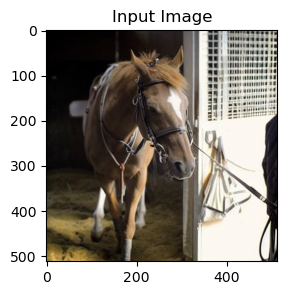

In [8]:
optimized_image, noise_list_1, xt_list_1 = img2img_sample(unet, generator=None, latents=ddim_latents, 
                                prompt="", uncond_embeddings_list=uncond_embeddings,
                                num_inference_steps=50, strength=1, guidance_scale=7.5,
                                do_classifier_free_guidance=True, return_noisy_latents_list=True, eta=0.0)

plt.figure(figsize=(3, 3))
plt.title('Input Image')
plt.imshow(optimized_image)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

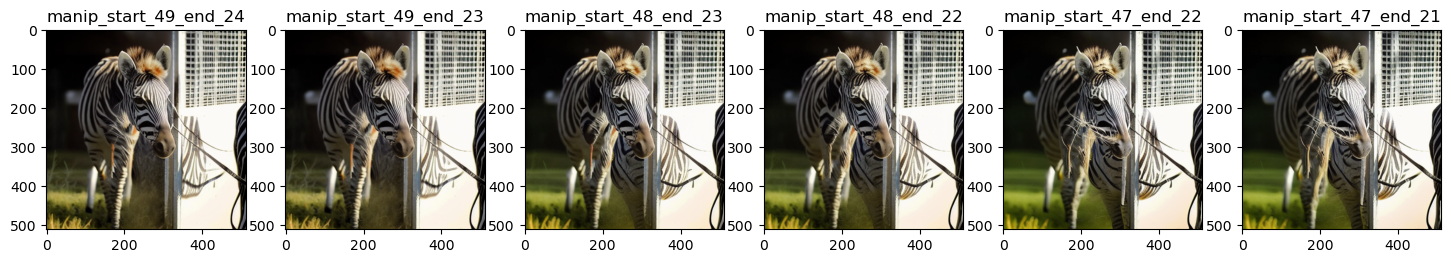

In [9]:
new_prompt = "Photo of a zebra"
manip_schedule_type = 'constant'
num_inference_steps = 50
tmax_range = (49, 46, -1)
tm_range = (25, 27, 1)
visualize_rows = 1
replaced_image_list = []
title_list = []

for start in range(tmax_range[0], tmax_range[1], tmax_range[2]):
    for steps in range(tm_range[0], tm_range[1], tm_range[2]):  
        end = start - steps   
        linear_factor_list = create_linear_factors_list(num_inference_steps, start, end, 
                                                        manip_schedule_type)
        
        replaced_image, noise_list_2 = mdp_epsilon(unet, generator=None, latents=ddim_latents,
                                        noise_list=noise_list_1, amplify=1,
                                        uncond_embeddings_list=uncond_embeddings,
                                        prompt=new_prompt,
                                        num_inference_steps=num_inference_steps, strength=1, 
                                        guidance_scale=7.5, return_noise_list=True,
                                        do_classifier_free_guidance=True, 
                                        linear_factor_list=linear_factor_list)
        
        replaced_image_list.append(replaced_image)
        
        title_list.append('manip_start_{}_end_{}'.format(start, start - steps))

visualize_images(replaced_image_list, cols=len(replaced_image_list) // visualize_rows, titles=title_list)

<font size="5">Synthetic Image Editing </font>

  0%|          | 0/50 [00:00<?, ?it/s]

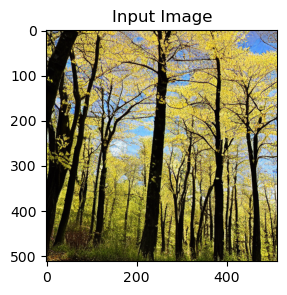

In [10]:
random_seed = 0
prompt = "Photo of a forest in the spring"
generator = torch.Generator(device=torch_device).manual_seed(random_seed)
optimized_image, noise_list_1, xt_list_1 = img2img_sample(unet, generator=generator, latents=None, 
                                prompt=prompt, uncond_embeddings_list=None,
                                num_inference_steps=50, strength=1, guidance_scale=7.5,
                                do_classifier_free_guidance=True, return_noisy_latents_list=True)

plt.figure(figsize=(3, 3))
plt.title('Input Image')
plt.imshow(optimized_image)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

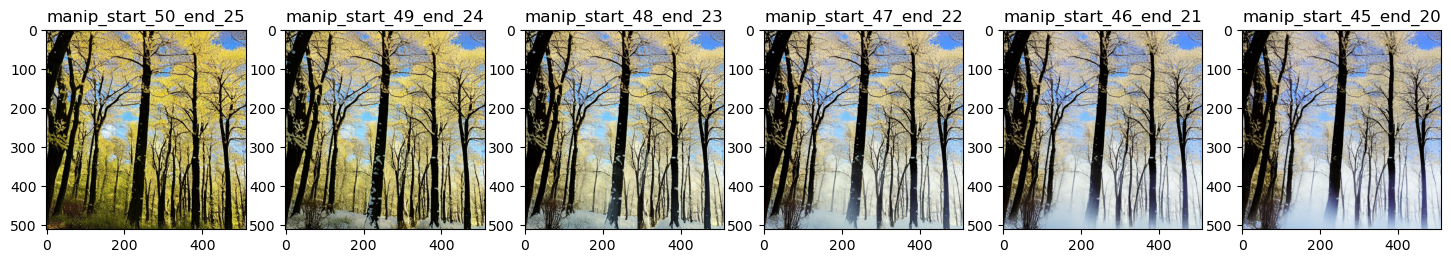

In [12]:
new_prompt = "A forest, winter"  # New prompt doesn't have to have the same structure as the input prompt
manip_schedule_type = 'constant'
num_inference_steps = 50
tmax_range = (50, 44, -1)  # manipulation start
tm_range = (25, 26, 1)  # manipulation duration
visualize_rows = 1
replaced_image_list = []
title_list = []

for start in range(tmax_range[0], tmax_range[1], tmax_range[2]):
    for steps in range(tm_range[0], tm_range[1], tm_range[2]):  
        end = start - steps   
        linear_factor_list = create_linear_factors_list(num_inference_steps, start, end, 
                                                        manip_schedule_type)
        
        generator = torch.Generator(device=torch_device).manual_seed(random_seed)
        replaced_image, noise_list_2 = mdp_epsilon(unet, generator=generator, latents=None,
                                        noise_list=noise_list_1, amplify=1,
                                        uncond_embeddings_list=None,
                                        prompt=new_prompt,
                                        num_inference_steps=num_inference_steps, strength=1, 
                                        guidance_scale=7.5, return_noise_list=True,
                                        do_classifier_free_guidance=True, 
                                        linear_factor_list=linear_factor_list)
        
        replaced_image_list.append(replaced_image)
        
        title_list.append('manip_start_{}_end_{}'.format(start, end))

visualize_images(replaced_image_list, cols=len(replaced_image_list) // visualize_rows, titles=title_list)